In [1]:
import numpy as np
import gymnasium as gym
import torch 
import torch.nn.functional as F
import collections
import random
from typing import Tuple
import matplotlib.pyplot as plt
import pandas as pd

The *naive* Q-learning with Q function approximation (Q_learning_NN.ipynb) shows a poor performance. One of the reasons is related to the sampling part. Since the continuous collected samples are highly correlated, the estimated expectation could be biased. To solve this problem, we can use the experience replay buffer. The experience replay buffer stores the samples in a buffer and randomly sample from the buffer to train the network. This can reduce the correlation between the samples.

We can use the same network structure as the naive Q-learning with Q function approximation. The only difference is that we use the experience replay buffer to store the samples and randomly sample from the buffer to train the network. The training process uses the samples from the experience replay buffer to update the network parameters. 
\begin{equation}
w_{t+1} \gets w_t - \alpha_t \left(r_{t+1}+\gamma \max_{a^{\prime} \in \mathcal{A}(s_{t+1})} \hat{q}\left(s_{t+1}, a^{\prime}, w_t\right)-\hat{q}(s_t, a_t, w_t)\right) \nabla_{w_t} \hat{q}(s_t, a_t, w_t)
\end{equation}
where \{$s_t$, $a_t$, $r_t$, $s_{t+1}$\} is uniformly sampled from the experience replay buffer.

In [2]:
class DQN_Agent():
    
    """ Since the discrete actions have been redefined as {0,1} by env, we can simply represent the action by a number. """
    
    def __init__(self,
                 Q_func: torch.nn.Module, 
                 action_dim: int,
                 optimizer: torch.optim.Optimizer,
                 replay_buffer: collections.deque, # Object of ReplayBuffer
                 replay_start_size: int, # The number of experiences stored in the replay buffer before learning starts
                 batch_size: int, # The number of experiences to sample from the replay buffer for every learning iteration
                 replay_frequent :int, # Train the network every {replay_frequent} steps, which would also help to decorrelate the samples
                 epsilon:float = 0.1,
                 gamma:float = 0.9,
                 device:torch.device = torch.device("cpu")
                 ) -> None:
        self.device = device
        self.action_dim = action_dim
        
        self.replay_buffer = replay_buffer
        self.replay_start_size = replay_start_size
        self.batch_size = batch_size
        self.replay_frequent = replay_frequent
        
        """Here, we set a Global Counter for **interactions with the environment**, which is used to determine when to update the target network."""
        self.exp_counter = 0 
        
        self.Q_func = Q_func
        self.criteria = torch.nn.MSELoss()
        self.optimizer = optimizer
        
        self.epsilon = epsilon
        self.gamma = gamma
        
    def get_target_action(self,obs:np.ndarray) -> int:
        obs = torch.tensor(obs,dtype=torch.float32,device=self.device)
        Q_list = self.Q_func(obs)
        action = torch.argmax(Q_list).item()
        return action

    def get_behavior_action(self,obs:np.ndarray) -> int:
        if np.random.uniform(0,1) < self.epsilon:
            action = np.random.choice(self.action_dim)
        else:
            action = self.get_target_action(obs)
            
        return action
    
    def batch_Q_approximation(self,
                              batch_obs:np.ndarray,
                              batch_action:np.ndarray,
                              batch_reward:np.ndarray,
                              batch_next_obs:np.ndarray,
                              batch_done:np.ndarray) -> None:
        
        """ Update the Q function by minimizing the TD-error """
        batch_current_Q = torch.gather(self.Q_func(batch_obs),1,batch_action).squeeze(1)
        batch_TD_target = batch_reward + (1-batch_done) * self.gamma * self.Q_func(batch_next_obs).max(1)[0] # torch.max returns a tuple (max_value, index_of_max_value)
        loss = self.criteria(batch_current_Q,batch_TD_target)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
            
    def Q_approximation(self,
                        obs:np.ndarray,
                        action:int,
                        reward:float,
                        next_obs:np.ndarray,
                        done:bool) -> None:
        """After each interaction with the environment, we call this function and check whether the replay buffer has enough experiences to start learning."""
        self.exp_counter += 1 # Update the Global Counter here, since we defined the counter in Agent class.
        self.replay_buffer.append((obs,action,reward,next_obs,done)) # Store the experience in the replay buffer
        
        # Start learning after the replay buffer has enough experiences
        if len(self.replay_buffer) > self.replay_start_size and self.exp_counter%self.replay_frequent == 0: 
            self.batch_Q_approximation(*self.replay_buffer.sample(self.batch_size))

In [3]:
class Q_Network(torch.nn.Module):
    """You can define your own network structure here."""
    def __init__(self,obs_dim:int,action_dim) -> None:
        super(Q_Network,self).__init__()
        self.fc1 = torch.nn.Linear(obs_dim,64)
        self.fc2 = torch.nn.Linear(64,action_dim)
            
    def forward(self,x:torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        
        return x

Here, we use python build-in libratory collections to implement the experience replay buffer. The deque is a double-ended queue. It can be used to add or remove elements from both ends. More details can be found in https://docs.python.org/2/library/collections.html#collections.deque. 

In this code, the replay will start after collecting certain number of experiences.

In [4]:
class ReplayBuffer():
    def __init__(self,capacity:int,device:torch.device = torch.device("cpu")) -> None:
        """The parameter "capacity" is the maximum number of experiences that can be stored in the replay buffer. 
            If the number of experiences exceeds the capacity, the oldest experiences will be removed."""
        self.device = device
        """Here, we use deque to implement the replay buffer. 
            Collections.deque is a double-ended queue, which supports adding and removing elements from either end."""
        self.buffer = collections.deque(maxlen=capacity)
        
    def append(self,exp_data:tuple) -> None:
        self.buffer.append(exp_data)
        
    def sample(self,batch_size:int) -> Tuple[torch.Tensor,torch.Tensor,torch.Tensor,torch.Tensor,torch.Tensor]:
        """Here, we use random.sample to randomly select a batch of experiences from the replay buffer.
            Note that the return type of random.sample is a list, we need to convert it to a numpy array to avoid low efficiency"""
        mini_batch = random.sample(self.buffer,batch_size)
        obs_batch, action_batch, reward_batch, next_obs_batch, done_batch = zip(*mini_batch)
        
        obs_batch = np.array(obs_batch)
        next_obs_batch = np.array(next_obs_batch)
        
        obs_batch = torch.tensor(obs_batch,dtype=torch.float32,device=self.device)
        
        action_batch = torch.tensor(action_batch,dtype=torch.int64,device=self.device) # for gather function, the index should be int type
        action_batch = action_batch.unsqueeze(1)
        
        reward_batch = torch.tensor(reward_batch,dtype=torch.float32,device=self.device)
        next_obs_batch = torch.tensor(next_obs_batch,dtype=torch.float32,device=self.device)
        done_batch = torch.tensor(done_batch,dtype=torch.int64,device=self.device)
          
        return obs_batch, action_batch, reward_batch, next_obs_batch, done_batch
    
    def __len__(self) -> int:
        return len(self.buffer)

In [5]:
class TrainManager():
    
    def __init__(self,
                 env:gym.Env,
                 episode_num:int = 1000,
                 lr:float = 0.001,
                 gamma:float = 0.9,
                 epsilon:float = 0.1,
                 buffer_capacity:int = 2000,
                 replay_start_size:int = 200,
                 replay_frequent:int = 4,
                 batch_size:int = 32,
                 seed = 0) -> None:
        
        self.seed = seed
        random.seed(self.seed)
        torch.manual_seed(self.seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(self.seed)
        torch.backends.cudnn.deterministic = True
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # self.device = torch.device("cpu")
                
        self.env = env
        self.episode_num = episode_num
        obs_dim = gym.spaces.utils.flatdim(env.observation_space) 
        action_dim = env.action_space.n
        self.buffer = ReplayBuffer(capacity=buffer_capacity,device=self.device)
        Q_func = Q_Network(obs_dim,action_dim).to(self.device)
        optimizer = torch.optim.Adam(Q_func.parameters(),lr=lr)
        self.agent = DQN_Agent(Q_func = Q_func,
                               action_dim = action_dim,
                               optimizer = optimizer,
                               replay_buffer = self.buffer,
                               replay_start_size = replay_start_size,
                               batch_size = batch_size,
                               replay_frequent=replay_frequent,
                               epsilon = epsilon,
                               gamma = gamma,
                               device = self.device)
        
        self.episode_total_rewards = np.zeros(episode_num)
        self.index_episode = 0  
        
    def train_episode(self,is_render:bool=False) -> float:
        total_reward = 0 
        obs,_ = self.env.reset(seed=self.seed) 
        while True:
            action = self.agent.get_behavior_action(obs) 
            next_obs, reward, terminated, truncated, _ = self.env.step(action) 
            done = terminated or truncated
            total_reward += reward 
            self.agent.Q_approximation(obs,action,reward,next_obs,done)
            obs = next_obs
            if is_render:
                self.env.render()
                                
            if done:
                self.episode_total_rewards[self.index_episode] = total_reward
                self.index_episode += 1
                break
            
        return total_reward       

    def test_episode(self) -> float:
        total_reward = 0 
        obs,_ = self.env.reset(seed=self.seed)
        while True:
            action = self.agent.get_target_action(obs) 
            next_obs, reward, terminated, truncated, _= self.env.step(action) 
            done = terminated or truncated 
            obs = next_obs
            total_reward += reward
            self.env.render()
            if done: break
            
        return total_reward
            
            
    def train(self) -> None:        
        for e in range(self.episode_num):
            episode_reward = self.train_episode()
            if e%100 == 0:
                print('Episode %s: Total Reward = %.2f'%(e,episode_reward)) 
            
            # if e % 100 == 0: 
            #     test_reward = self.test_episode()
            #     print('Test Total Reward = %.2f'%(test_reward))
            
            
    def plotting(self,smoothing_window:int = 100) -> None:    
        """ Plot the episode reward over time. """
        fig = plt.figure(figsize=(10,5))
        plt.plot(self.episode_total_rewards,label="Episode Reward")
        # Use rolling mean to smooth the curve
        rewards_smoothed = pd.Series(self.episode_total_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
        plt.plot(rewards_smoothed,label="Episode Reward (Smoothed)")
        plt.xlabel('Episode')
        plt.ylabel('Episode Reward')
        plt.title("Episode Reward over Time")
        plt.legend()
        plt.show()

c:\Users\gemin\miniconda3\envs\pytorch\lib\site-packages\gymnasium\envs\registration.py:523: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


Episode 0: Total Reward = 11.00
Episode 100: Total Reward = 11.00
Episode 200: Total Reward = 36.00
Episode 300: Total Reward = 35.00
Episode 400: Total Reward = 58.00
Episode 500: Total Reward = 124.00
Episode 600: Total Reward = 45.00
Episode 700: Total Reward = 200.00
Episode 800: Total Reward = 153.00
Episode 900: Total Reward = 200.00


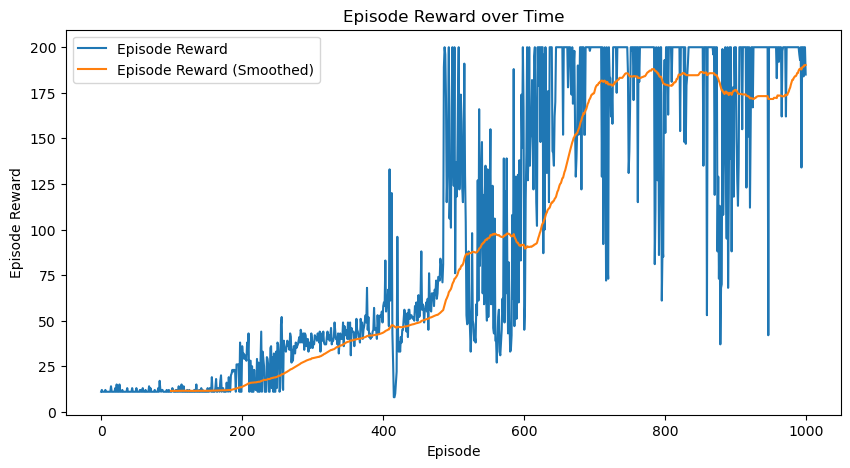

In [6]:
if __name__ == "__main__":
    env = gym.make('CartPole-v0')
    Manger = TrainManager(env = env,
                        episode_num = 1000,
                        lr = 0.001,
                        gamma = 0.9,
                        epsilon = 0.1
                        )
    Manger.train()
    Manger.plotting()
    